# Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ⏯ Directories

In [ ]:
ROOT = '/content/drive/MyDrive/xBD_dataset/'

test = 'xView2_test/test/'
train = 'xView2_train/train/'
hold = 'xView2_hold/hold/'
tier3 = 'xView2_tier3/tier3/'

SUB = ['images', 'labels', 'targets']

## 📚 Libraries

In [ ]:
import os
import glob

import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
from time import sleep

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam
# from tensorflow.keras.metrics import MeanIoU  # , OneHotMeanIoU
from tensorflow.keras.layers import Input, Concatenate, Conv2D, BatchNormalization, Activation, Dense
from keras.models import Model

import albumentations as A
from skimage.io import imread

## 📧 Read database

In [ ]:
with open(f'{ROOT}/All_Data_Props.pkl', 'rb') as f:
    db = pkl.load(f)

## ⏬ Install Libraries

In [ ]:
!pip install -U segmentation-models

In [ ]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm

import keras
keras.backend.set_image_data_format('channels_last')

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


In [ ]:
from keras.initializers import he_normal

## ♻ Data generator definition

In [ ]:
class xBD_DataGenerator(keras.utils.Sequence):
    def __init__(self, path_to_jsons, batch_size=5, patch_size=256,
                 shuffle=True, classification=True, preprocessing=None):

        # Initialization -->
        self.path_to_jsons = path_to_jsons
        self.pre_img_paths = []
        self.post_img_paths = []
        self.loc_target_paths = []
        self.cls_target_paths = []

        for i in range(len(self.path_to_jsons)):
            # pre-disaster images
            self.pre_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/').replace('_post_', '_pre_') + '.png')
            # post-disaster images
            self.post_img_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/images/') + '.png')
            if 'tier3' not in self.path_to_jsons[i]:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_post_', '_pre_') + '_target.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '_target.png')
            else:
              # localization targets
              self.loc_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/').replace('_post_', '_pre_') + '.png')
              # classification targets
              self.cls_target_paths.append(self.path_to_jsons[i].replace('Shareddrives/UnlimitedDrive/Thesis', 'MyDrive').replace('/labels/', '/targets/') + '.png')

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.classification = classification    # Whether you want to perform classification or localization.
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

        self.on_epoch_end()
        self.preprocessing = preprocessing

    def __len__(self):
        # Denotes the number of batches per epoch (steps per epoch) [N_batch]
        return int(len(self.pre_img_paths) // self.batch_size)

    def __getitem__(self, idx):
        # Returns image indices of a batch
        # Generate one batch of data
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        pre_image_batch = list(np.array(self.pre_img_paths)[batch_indices])
        post_image_batch = list(np.array(self.post_img_paths)[batch_indices])
        loc_target_batch = list(np.array(self.loc_target_paths)[batch_indices])
        cls_target_batch = list(np.array(self.cls_target_paths)[batch_indices])

        # Generates data containing batch_size samples # X : (n_samples, *dim, n_channels)
        # Initialization
        x_pre_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        x_post_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (3,), dtype='float32')
        y_target_batch = np.empty((self.batch_size,) + (self.patch_size, self.patch_size) + (5,), dtype='float32')
        # Generate data
        for b in range(self.batch_size):
            pre_image = imread(pre_image_batch[b])
            post_image = imread(post_image_batch[b])
            if self.classification:
                target_image = imread(cls_target_batch[b])
                # Treat "unclassified" as no-damage
                target_image[target_image == 5] = 1

                # for CATEGORICAL ONE-HOT classes
                categorical = np.zeros((target_image.shape[0], target_image.shape[1], 5))
                categorical[:, :, 0] = target_image == 0
                categorical[:, :, 1] = target_image == 1
                categorical[:, :, 2] = target_image == 2
                categorical[:, :, 3] = target_image == 3
                categorical[:, :, 4] = target_image == 4
                target_image = categorical

            else:
                target_image = imread(loc_target_batch[b])

            # Perform a random cropping and put images into batch array.
            r_start, c_start = np.random.randint(low=0, high=(pre_image.shape[0] - self.patch_size), size=2)
            x_pre_batch[b] = self.preprocessing(pre_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])       # preprocess input images based on backbone preprocessing
            x_post_batch[b] = self.preprocessing(post_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :])     # preprocess input images based on backbone preprocessing
            y_target_batch[b] = target_image[r_start:r_start+self.patch_size, c_start:c_start+self.patch_size, :]

        return (x_pre_batch, x_post_batch), y_target_batch

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pre_img_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Training data generation
training_files = []
cond00 = db['Group'] == 'Train'                # use images in Train folder
cond01 = db['Group'] == 'Tier3'                # use images in Train folder
cond1 = db['buildings#'] > 20                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['minor-damage#'] + db['major-damage#'] > 10
training_files = list(db[(cond00 | cond01) & cond2 & cond3]['img_name'])
# training_files = list(db[cond00 & cond2 & cond3]['img_name'])
print(len(training_files))

# Testing data generation
testing_files = []
cond0 = db['Group'] == 'Test'                 # use images in Train folder
cond1 = db['destroyed#'] > 0                  # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['major-damage#'] + db['minor-damage#'] > 5
testing_files = list(db[cond0 & cond2 & cond3]['img_name'])
print(len(testing_files))

# Validation data generation
validation_files = []
cond0 = db['Group'] == 'Hold'                 # use images in Train folder
cond1 = db['buildings#'] > 30                 # ensure there are buildings
cond2 = db['Pre_Post'] == 'post'              # choose from pre or post
cond3 = db['destroyed#'] + db['minor-damage#'] + db['major-damage#'] > 20
validation_files = list(db[cond0 & cond2 & cond3]['img_name'])
print(len(validation_files))

1310
292
155


# UNet (segmentation models: efficientnet and resnet)

https://github.com/qubvel/segmentation_models

## ✌ Make it DOUBLE!

### Constants and Data

In [ ]:
BACKBONE = 'resnet34'  # 'efficientnetb7' #
preprocess_input = get_preprocessing(BACKBONE)
BATCH = 10
PATCH = 256
CLASSES = ['no-damage', 'minor-damage', 'major-damage', 'destroyed']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
EPOCHS = 20
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:
parameters = {'shuffle': True, 'batch_size': BATCH, 'patch_size': PATCH, 'classification': True, 'preprocessing': preprocess_input}

train_generator = xBD_DataGenerator(path_to_jsons=training_files, **parameters)
test_generator = xBD_DataGenerator(path_to_jsons=testing_files, **parameters)
valid_generator = xBD_DataGenerator(path_to_jsons=validation_files, **parameters)

### ⬛ Define the base model (without its last layer)

In [ ]:
# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:-num_top_layer_in_base_model_to_train]:
#     layer.trainable = False


# #Free the batch norm layers
# for layer in base_model.layers[num_top_layer_in_base_model_to_train:]:
#     if isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False

In [ ]:
localization_model = Unet(BACKBONE, classes=1, encoder_weights='imagenet', encoder_freeze=True, activation='sigmoid', input_shape=(PATCH, PATCH, 3))
localization_model.load_weights(f'/content/drive/MyDrive/model.sm.{BACKBONE}.unet.h5')
localization_branch = Model(inputs=localization_model.inputs, outputs=localization_model.get_layer('decoder_stage4b_relu').output)
localization_branch.trainable = False


def decay_schedule(epoch, lr):
    if epoch < 3:
        lr = 0.01
    elif (epoch >= 3) and (epoch < 6):
        lr = 0.001
    elif (epoch >= 6) and (epoch < 8):
        lr = 0.0001
    elif epoch >= 8:
        localization_branch.trainable = True
        lr = 0.00001
    return lr

# Various Loss functions can be tested.
dice_loss = sm.losses.DiceLoss()
f_loss = sm.losses.CategoricalFocalLoss()
ce_loss = sm.losses.CategoricalCELoss()
# total_loss = dice_loss + f_loss + ce_loss
total_loss = 'categorical_crossentropy'   #

lr_scheduler = LearningRateScheduler(decay_schedule)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Different metrics
metrics = ['accuracy', 'categorical_accuracy', sm.metrics.FScore(threshold=0.5)]
# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]    # Better to avoid IoU metric!
# metrics = [MeanIoU(num_classes=4)]# , sparse_y_pred=False)]                         # Does Not Work
# metrics = [OneHotMeanIoU(num_classes=4, sparse_y_pred=False)]                       # Does Not Work

callbacks = [
    keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/model.sm.{BACKBONE}-unet-double.unet-22Aug_02.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    lr_scheduler,
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, start_from_epoch=10, patience=5,)
]

85521592/85521592 [==============================] - 5s 0us/step


### ❓ Localization works?

In [ ]:
(x_pre, x_post), y_mask = test_generator.__getitem__(13)
print(np.min(x_pre), np.max(x_pre), np.min(x_post), np.max(x_post))
x_test_output = localization_model.predict(x_pre)
x_test_output[x_test_output < 0.01] = 0
for i in range(BATCH):
    plt.figure()
    plt.subplot(121), plt.imshow((x_pre[i] - np.min(x_pre[i])) / np.max(x_pre[i] - np.min(x_pre[i])))
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(x_test_output[i])
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

### 🥂 Construct the siamese netowrk + segmentation head

In [ ]:
input_pre = Input(shape=(PATCH, PATCH, 3), name="pre_input")
output_pre = localization_branch(input_pre)

input_post = Input(shape=(PATCH, PATCH, 3), name="post_input")
output_post = localization_branch(input_post)


# Segmentation Head can be configured to get different results.
head = Concatenate()([output_pre, output_post])
# new from here -----------------
head = BatchNormalization()(head)
head = Activation("relu")(head)
head = Conv2D(8, (3, 3), padding='same', kernel_initializer=he_normal(), name='middle_conv')(head)
head = BatchNormalization()(head)
head = Activation("relu")(head)
# to here -----------------------
head = Conv2D(n_classes, (3, 3), padding='same', kernel_initializer=he_normal(), name='class_conv')(head)
output = Activation("sigmoid")(head)

classification_model = Model([input_pre, input_post], output)
classification_model.compile(optimizer, loss=total_loss, metrics=metrics)

The probelm of not learning, not (over-)fitting, and not even changing the MeanIoU metric:
- IoU requires integer class values. Which means that the sigmoid values must be thresholded in order to become 0 or 1 (for binary) and Integers (for multiclass) segmentation.
- Keras MeanIoU does not have the thresholding part [ref](https://stackoverflow.com/questions/59990587/tf-keras-metrics-meaniou-with-sigmoid-layer). Thus, it considers every value between 0 and 1, as 0; and only 1 is considered 1.
- So, as a result, nothing changes in the predictions, because MeanIoU function is computing wrong values.
- There are no GOOD solutions for this.
>- one is to update Keras MeanIoU function with an UPDATE function.
>- another one is to use our own code for IoU score (the current case is segmentation-models code).
>- > one solution which is described in Keras documents is to set `sparse_y_pred=False` in the function input. But, it generates `unknown input argument error`.
>- > another solution is to use `OneHotMeanIoU` of Keras; which again is not working and has the same problem.

In [ ]:
history = classification_model.fit(
    train_generator,
    # validation_data=train_generator,    # for overfit
    validation_data=valid_generator,
    use_multiprocessing=True,
    workers=6, epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
# class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
#     def __init__(self,
#                y_true=None,
#                y_pred=None,
#                num_classes=None,
#                name=None,
#                dtype=None):
#         super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.math.argmax(y_pred, axis=-1)
#         return super().update_state(y_true, y_pred, sample_weight)

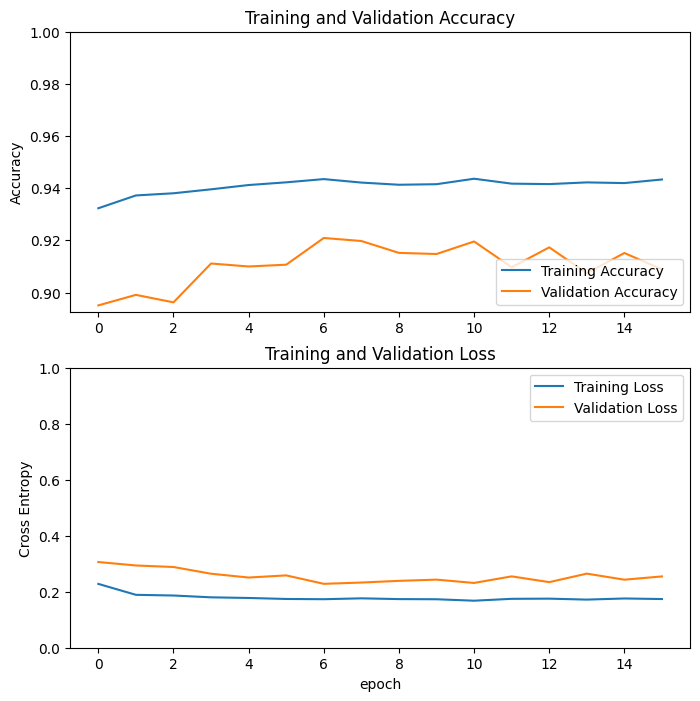

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 👀 Let's see

### Visualize predictions
Visualize classification prediction results.

In [ ]:
classification_model.load_weights(f'/content/drive/MyDrive/model.sm.{BACKBONE}-unet-double.unet-22Aug_01.h5')

In [ ]:
(x_pre, x_post), y_mask = test_generator.__getitem__(10)
a = classification_model.predict([x_pre, x_post])

plt.figure(figsize=(10, 5))
for i in range(BATCH):
    plt.subplot(2, BATCH, i + 1), plt.xticks([]), plt.yticks([]), plt.title('pre')
    # plt.imshow(x_pre[i].astype(int))
    plt.imshow((x_pre[i] - np.min(x_pre[i])) / np.max(x_pre[i] - np.min(x_pre[i])))

    plt.subplot(2, BATCH, i + BATCH + 1), plt.xticks([]), plt.yticks([]), plt.title('post')
    # plt.imshow(x_post[i].astype(int))
    plt.imshow((x_post[i] - np.min(x_post[i])) / np.max(x_post[i] - np.min(x_post[i])))

plt.tight_layout()
plt.show()

#### Trying on TP, FP, FN, and TN. Applying color maps.

In [ ]:
c = mpl.colors.ListedColormap(['midnightblue', 'green', 'ivory', 'orange', 'red'])
n = mpl.colors.Normalize(vmin=0, vmax=5)

c1 = mpl.colors.ListedColormap(['white', 'red', 'blue', 'lime'])
n1 = mpl.colors.Normalize(vmin=1, vmax=4)

In [ ]:
for i in range(BATCH):
    x_pre[i] = (x_pre[i] - np.min(x_pre[i])) / np.max(x_pre[i] - np.min(x_pre[i]))
    x_post[i] = (x_post[i] - np.min(x_post[i])) / np.max(x_post[i] - np.min(x_post[i]))

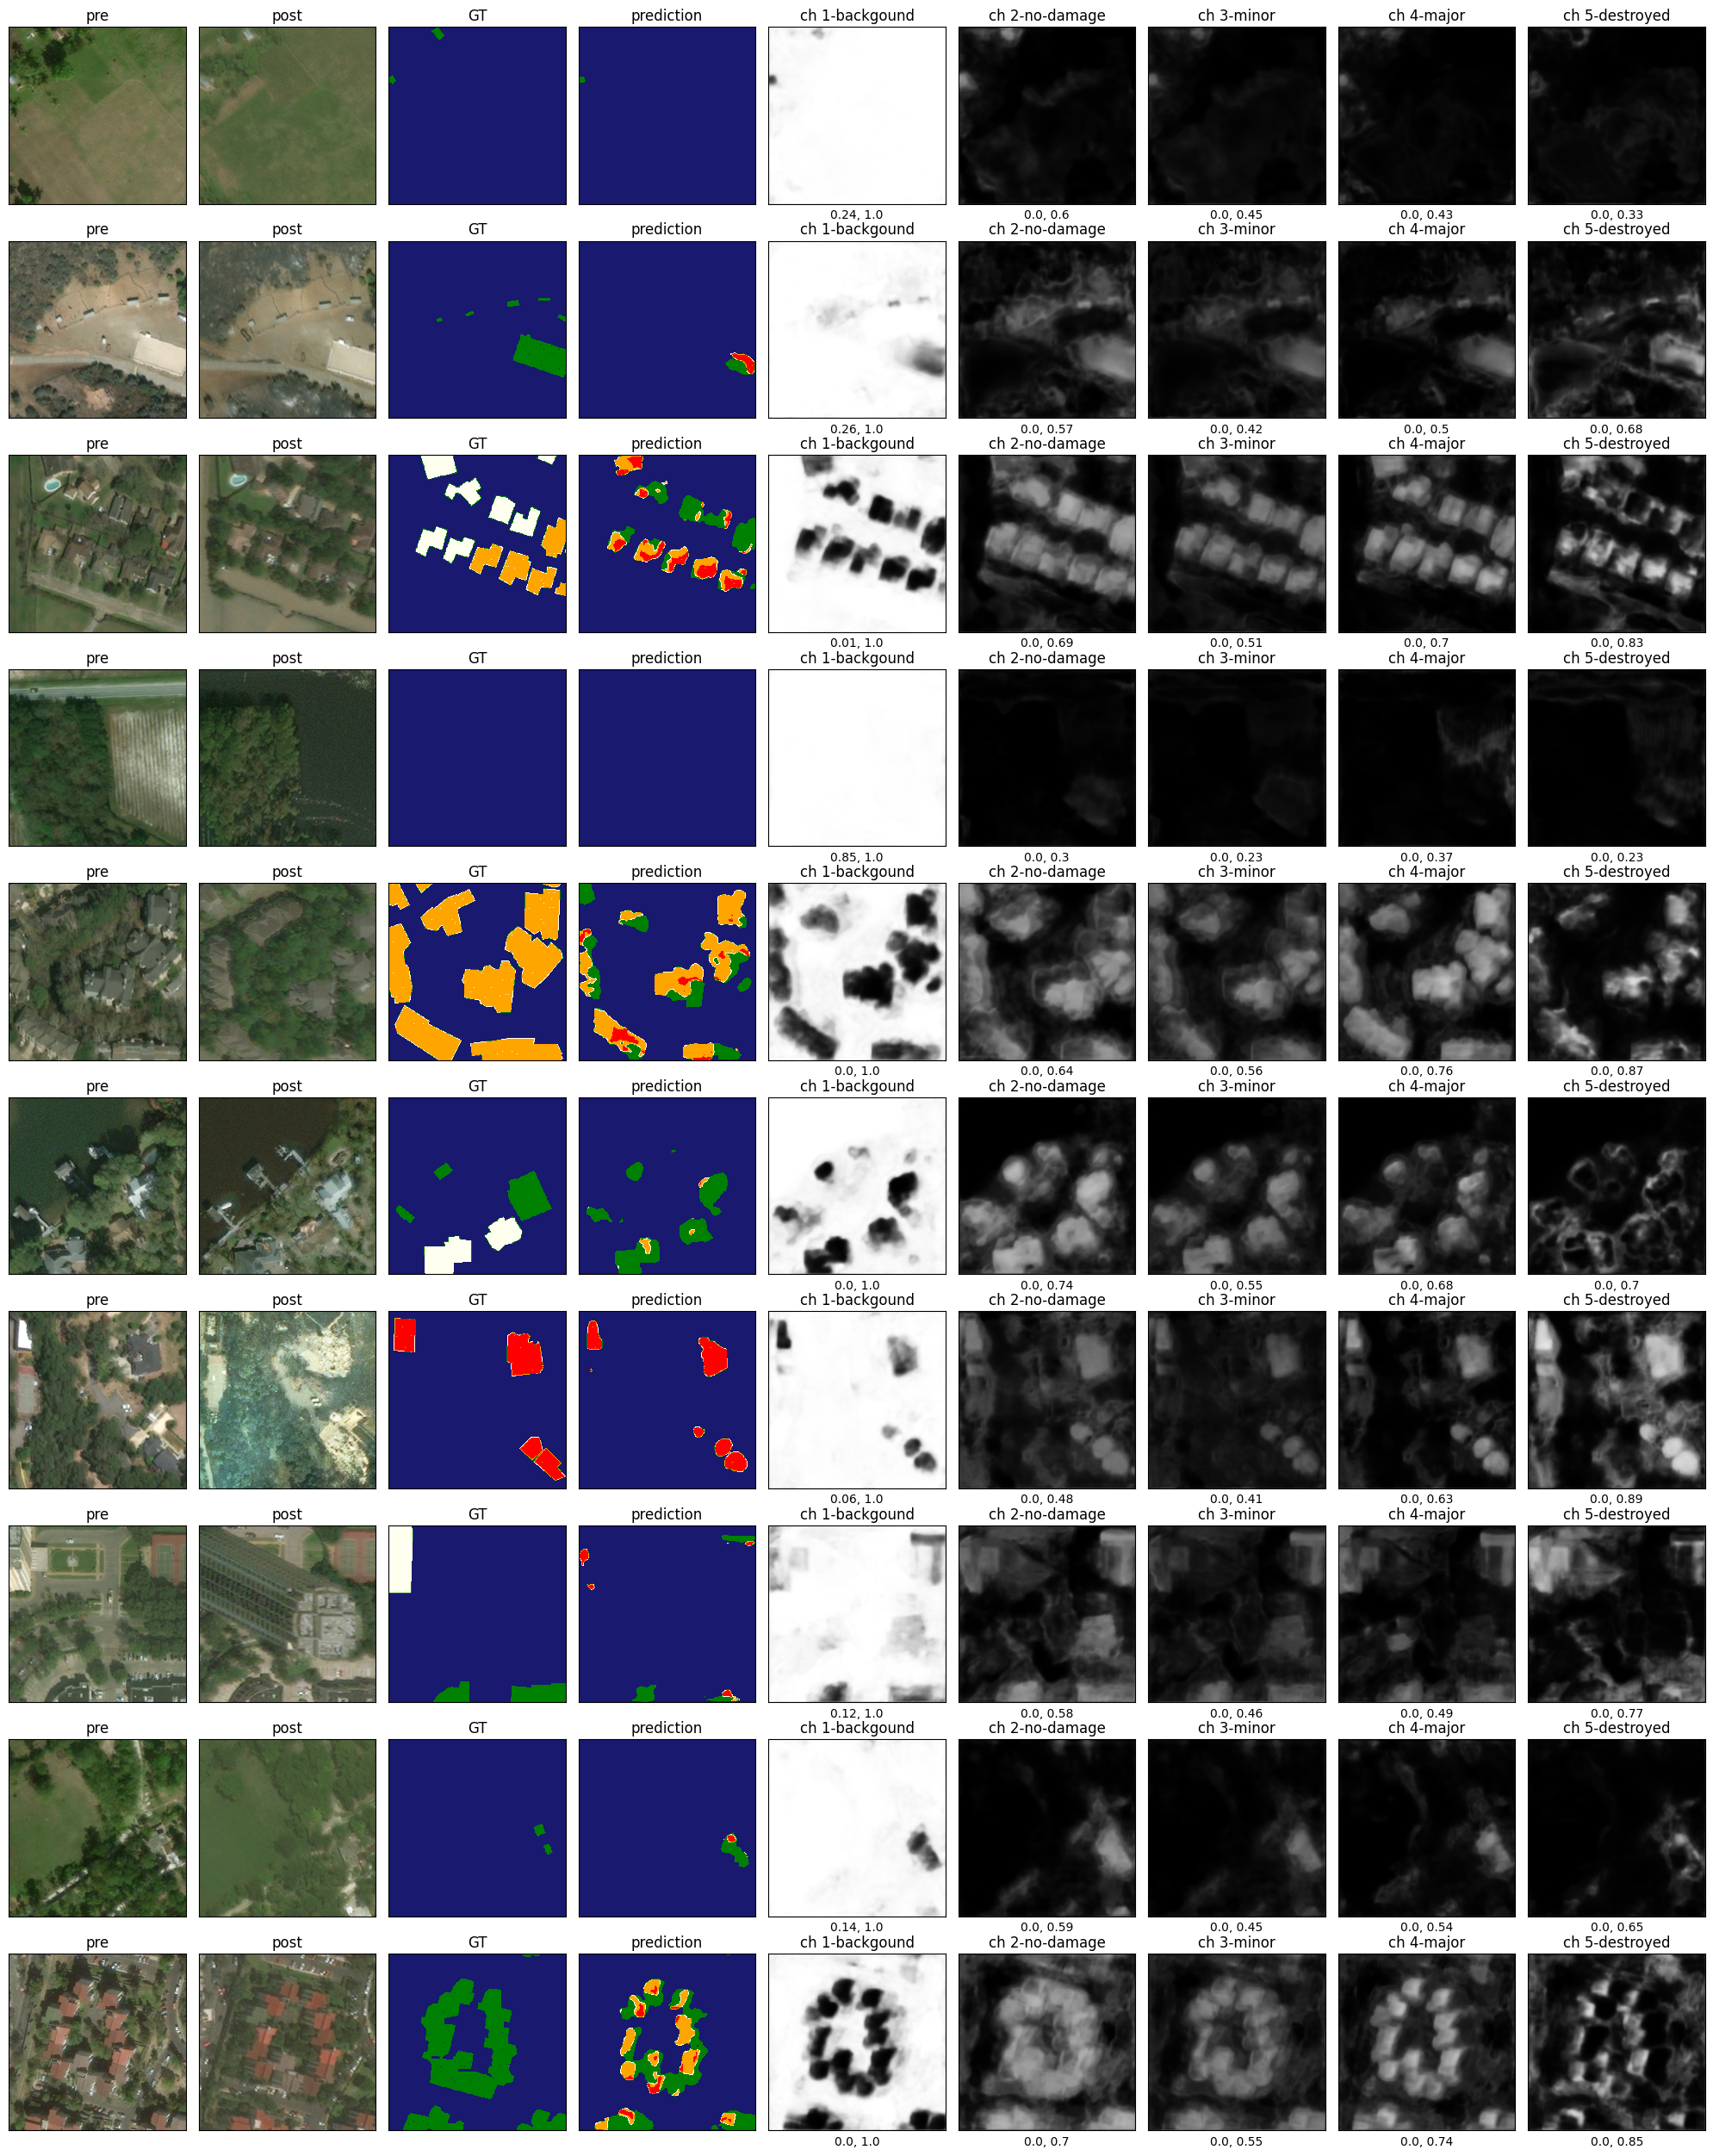

In [ ]:
count = 1
plt.figure(figsize=(20, BATCH*2.5))
for i in range(BATCH):
    plt.subplot(BATCH, 9, count), plt.xticks([]), plt.yticks([])
    plt.imshow(x_pre[i].astype(int)), plt.title('pre')
    plt.subplot(BATCH, 9, count+1), plt.xticks([]), plt.yticks([])
    plt.imshow(x_post[i].astype(int)), plt.title('post')
    plt.subplot(BATCH, 9, count+2), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(y_mask[i], axis=2), cmap=c, norm=n), plt.title('GT')

    plt.subplot(BATCH, 9, count+3), plt.xticks([]), plt.yticks([])
    plt.imshow(np.argmax(a[i], axis=2), cmap=c, norm=n), plt.title('prediction')

    plt.subplot(BATCH, 9, count+4), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 0]), 2))
    max_ = str(round(np.max(a[i, :, :, 0]), 2))
    plt.imshow(a[i, :, :, 0], vmin=0, vmax=1, cmap='gray'), plt.title('ch 1-backgound'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(BATCH, 9, count+5), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 1]), 2))
    max_ = str(round(np.max(a[i, :, :, 1]), 2))
    plt.imshow(a[i, :, :, 1], vmin=0, vmax=1, cmap='gray'), plt.title('ch 2-no-damage'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(BATCH, 9, count+6), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 2]), 2))
    max_ = str(round(np.max(a[i, :, :, 2]), 2))
    plt.imshow(a[i, :, :, 2], vmin=0, vmax=1, cmap='gray'), plt.title('ch 3-minor'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(BATCH, 9, count+7), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 3]), 2))
    max_ = str(round(np.max(a[i, :, :, 3]), 2))
    plt.imshow(a[i, :, :, 3], vmin=0, vmax=1, cmap='gray'), plt.title('ch 4-major'), plt.xlabel(min_ + ', ' + max_)

    plt.subplot(BATCH, 9, count+8), plt.xticks([]), plt.yticks([])
    min_ = str(round(np.min(a[i, :, :, 4]), 2))
    max_ = str(round(np.max(a[i, :, :, 4]), 2))
    plt.imshow(a[i, :, :, 4], vmin=0, vmax=1, cmap='gray'), plt.title('ch 5-destroyed'), plt.xlabel(min_ + ', ' + max_)

    count += 9
plt.tight_layout()
plt.show()

In [ ]:
i = 4
pred_i = np.argmax(a[i], axis=2)
gt_i = np.argmax(y_mask[i], axis=2)

# THESE MEASURES WORK ONLY FOR LOCALIZATION VISUALIZATION (they must be configured to work for multiclass segmentation, too)
TN = (gt_i == 0) & (pred_i == 0)
# TP = (gt_i == pred_i) * ~TN
TP = (gt_i != 0) * (pred_i != 0)
# TP = (np.abs(pred_i - gt_i) < 2) * ~TN
FP = (pred_i != 0) * (gt_i == 0)
# FP = (pred_i != gt_i) * ~TN
FN = (pred_i == 0) * (gt_i != 0)

plt.figure(figsize=(15, 5))
# plt.subplot(161), plt.imshow(gt_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
# plt.subplot(162), plt.imshow(pred_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
# plt.subplot(163), plt.imshow(TN), plt.xticks([]), plt.yticks([])
# plt.subplot(164), plt.imshow(TP), plt.xticks([]), plt.yticks([])
# plt.subplot(165), plt.imshow(FP), plt.xticks([]), plt.yticks([])
# plt.subplot(166), plt.imshow(FN), plt.xticks([]), plt.yticks([])
plt.subplot(131), plt.imshow(gt_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(pred_i, cmap=c, norm=n), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(TN * 1 + FN * 2 + FP * 3 + TP * 4, cmap=c1, norm=n1), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(x_pre[i].astype(int)), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(x_post[i].astype(int)), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

### Visualize features

In [ ]:
fm1 = Model(inputs=classification_model.inputs, outputs=classification_model.get_layer('model_1').output)
o1 = fm1.predict([x_pre, x_post])
o1.shape

In [ ]:
fm1 = Model(inputs=classification_model.inputs, outputs=classification_model.get_layer('class_conv').output)
o1 = fm1.predict([x_pre, x_post])
o1.shape

1/1 [==============================] - 14s 14s/step


(5, 256, 256, 5)

In [ ]:
count = 1
plt.figure(figsize=(8, 8))
for i in range(BATCH):
    for j in range(o1.shape[-1]):
        plt.subplot(BATCH, o1.shape[-1], count), plt.xticks([]), plt.yticks([])
        plt.imshow(o1[i, :, :, j])
        print(i, j, count, np.min(o1[i, :, :, j]), np.max(o1[i, :, :, j]))
        count += 1
plt.tight_layout()
plt.show()

In [ ]:
b = localization_branch.predict(x_pre)
b.shape

1/1 [==============================] - 30s 30s/step


(5, 512, 512, 16)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1), plt.xticks([]), plt.yticks([])
    plt.imshow(b[0, :, :, i])
plt.tight_layout()
plt.show()